In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import corner
import astropy as ap
import astropy.io.fits as pyfits
import pandas as pd
import math
import statistics
import scipy.ndimage as ndimage
import lenstronomy.Util.kernel_util as kernel_util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.Util import util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from memory_profiler import memory_usage
plt.style.use(astropy_mpl_style)
%matplotlib inline


In [13]:
# DES camera specifics
exp_time = 90.  # exposure time
numPix = 46  # number of pixels in image
deltaPix = 0.2637   # pixel size in arcsec


In [14]:
# General functions
def get_data(filename):
    """
    Input: filename
    Output: pandas data table and image array (46,46,3,3)
    """
    hdu_list = fits.open(filename)
    data = pd.DataFrame(hdu_list[2].data)  # get dataframe data
    image = hdu_list['IMAGE'].data  # get image data
    # print(data.columns)  # view all column names
    hdu_list.close()  # close
    return data, image


def plot_image(image_array):
    """
    Input: image array
    Output: image with no grid or axis ticks
    """
    fig, ax = plt.subplots()
    ax.imshow(image_array, origin='lower')
    ax.set_xticks([])
    ax.set_xticks([])
    ax.grid(False)
    plt.show()
    plt.close()

In [15]:
# General lensing functions
def approx_theta_E(center_x, center_y, x_images, y_images):
    """
    Input: Lens position (center_x, center_y) and image positions
    Output: theta_E estimated as average of distances from image to lens
    """
    d = []
    for i in range(0, len(x_images)):
        x = float(x_images[i])
        y = float(y_images[i])
        x = center_x - x
        y = center_y - y
        dist = math.sqrt(x**2+y**2)
        d.append(dist)
    theta_E = statistics.mean(d)
    print(f"'Estimated theta_E': {round(theta_E, 2)}")
    return theta_E


def add_mask(band, kwargs_data, kwargs_psf, mask_2d):
    """
    Input: band (g,r,i) plus corresponding kwargs_data and kwargs_psf,
           kwargs_numerics
    Output: kwargs_data with masked image
    """
    # settings
    data_class = ImageData(**kwargs_data)
    psf_class = PSF(**kwargs_psf)
    kwargs_numerics = {'supersampling_factor': 1,
                       'supersampling_convolution': False}
    imageFit = ImageLinearFit(data_class=data_class,
                              psf_class=psf_class,
                              kwargs_numerics=kwargs_numerics,
                              likelihood_mask=mask_2d)
    # apply mask to image
    mask_1d = imageFit.image2array_masked(band)
    masked_image = imageFit.array_masked2image(mask_1d)

    # update kwargs_data with masked image
    kwargs_data.update({'image_data': masked_image})

    return kwargs_data, masked_image


def model_plot_all_bands(modelPlot):
    """
    Input: modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result,
                                 arrow_size=0.02, cmap_string="gist_heat")
    Output: 3x3 figure where each row is a band (G,R,I) and
            columns are observed, reconstructed, and normalized residuals
    """
    f, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 fig
    # set row names: names must be in same order as multi_band_list
    band_names = ['G', 'R', 'I']
    for index, band_name in enumerate(band_names):
        axes[index, 0].set_title(str(band_name)+'-Band')
        modelPlot.data_plot(ax=axes[index, 0], band_index=index)
        # image_names=False hides image points
        modelPlot.model_plot(ax=axes[index, 1],
                             image_names=True, band_index=index)
        modelPlot.normalized_residual_plot(ax=axes[index, 2],
                                           v_min=-6, v_max=6,
                                           band_index=index)
    plt.show()
    plt.close()


In [16]:
# PSF Functions
def set_pixel_psf(coadd_id, band_index):
    """
    Input: coadd_id and band_index (g=0, r=1, i=2)
    Output: PIXEL psf model from fits file
    """
    # get data from fits file
    psf_filename = filepath + 'stars.fits'  # psf model from near field star
    psf_data, psf_image = get_data(psf_filename)

    # index by candidate's coadd_id
    psf_row = psf_data[psf_data['COADD_OBJECT_ID_CAND'] == coadd_id].index[0]

    # crop kernel to odd number
    kernel = psf_image[psf_row, band_index, 0:45, 0:45]

    # crop kernel to just psf
    kernel_centered = kernel_util.center_kernel(kernel, iterations=20)
    kernel_size = 13
    kernel_cut = kernel_util.cut_psf(kernel_centered, kernel_size)

    # set psf model
    kwargs_psf = {'psf_type': 'PIXEL',
                  'pixel_size': deltaPix,
                  'kernel_point_source': kernel_cut}

    # plot kernel for reference
    plot_image(kernel_cut)
    return kwargs_psf


def set_gauss_psf(fwhm):
    """
    Input: fwhm
    Output: Pixel type kwargs_psf with gaussian kernel
    
    """
    # set GAUSSIAN psf
    kwargs_psf = {'psf_type': 'GAUSSIAN',
                  'fwhm': fwhm,
                  'pixel_size': deltaPix,
                  'truncation': 4}

    # convert GAUSSIAN type to kernel for PIXEL type
    psf = PSF(**kwargs_psf)
    kernel = psf.kernel_point_source
    error_map = psf.psf_error_map

    # set type as PIXEL with GAUSSIAN kernel and error map
    kwargs_psf_pix = {'psf_type': 'PIXEL', 'pixel_size': deltaPix,
                      'fwhm': fwhm, 'kernel_point_source': kernel,
                      'psf_error_map': error_map}
    return kwargs_psf_pix


In [17]:
# RMS functions
def get_hist_stats(flat_image):
    """
    Input: 1d numpy array of image (flattened image)
           note: to flatten an image use '1d_array = 2d_array.flatten()'
    Output: number of bins for histogram based on spread of data,
            integer values of min and max (used for range of x-axis)
            root mean square value
    """
    min_int = math.floor(np.amin(flat_image))  # round min down to int
    max_int = math.ceil(np.amax(flat_image))  # round max up to int
    Bins = abs(min_int)+max_int  # num bins = one per integer value
    rms = np.sqrt(np.mean(flat_image**2))  # calculate rms
    return Bins, min_int, max_int, rms


def get_rms_fast(filename, coadd_id, crop):
    """
    Input: filename, coadd_id of image, and background region
           region = crop = [[x_lower, x_upper], [y_lower, y_upper]]
    Output: rms_list in order g,r,i
    """
    data, image = get_data(filename)
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    # crop g,r,i bands to region
    g_crop = image[row, 0, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    r_crop = image[row, 1, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
    i_crop = image[row, 2, crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]

    # list of flattened images (1d image arrays)
    band_flats = [g_crop.flatten(), r_crop.flatten(), i_crop.flatten()]
    rms_list = []  # rms values will be saved here and returned

    # loop to get rms for each band
    for index, flat_image in enumerate(band_flats):
        _, _, _, rms = get_hist_stats(flat_image)  # get rms
        rms_list.append(rms)  # save rms

    return rms_list

In [18]:
# set filenames
filepath = '/Users/gilliancartwright/Desktop/DES data/'  # personal file path
filename = filepath + 'Rob_candidates.fits'  # pre-cropped images
psf_filename = filepath + 'stars.fits'  # near field bright star psf
rms_filename = filepath + 'Rob_candidates_larger.fits'  # larger background

# show data table for reference
data, image = get_data(filename)
data.head(3)


COADD_OBJECT_ID      TILENAME  HPIX_16384  HPIX_4096  DNF_ZMEAN_SOF  \
0       1400263522  DES0336-2915  2354916223  147182263       0.938449   
1       1325853948  DES0242-0041  1163420627   72713789       0.006323   
2       1087262176  DES0038-4414  2318857161  144928572       0.545765   

          RA        DEC  FLUX_RADIUS_G  FLUX_RADIUS_R  FLUX_RADIUS_I  ...  \
0  53.898900 -28.912203       3.962615       4.879757       4.983489  ...   
1  40.969310  -0.619002      10.245866      10.665524      11.179090  ...   
2  10.155908 -44.437518       5.865641       5.180269       5.163048  ...   

   FWHM_WMEAN_G  FWHM_WMEAN_R  FWHM_WMEAN_I  FWHM_WMEAN_Z  SKYBRITE_WMEAN_G  \
0       1.09654      0.943639      0.817035      0.899360        390.652008   
1       1.09442      0.956736      0.894366      0.889644        459.313995   
2       1.28928      1.035290      1.025070      0.777657        406.477997   

   SKYBRITE_WMEAN_R  SKYBRITE_WMEAN_I  SKYBRITE_WMEAN_Z           NAME  \
0        947.728027       3299.189941       7099.970215  DES-691022126   
1       1283.849976       3451.110107       8414.360352  DES-701263907   
2       1063.030029       2966.409912       8586.750000  DES-699919273   

    NAME_FOLDER  
0  DES0336-2915  
1  DES0242-0041  
2  DES0038-4414  

[3 rows x 36 columns]

In [19]:
# MODEL FUNCTION
def model(coadd_id, kwargs_lens_initial, kwargs_lens_light_initial,
          x_images, y_images, mask_list, psf_type, rms_list):
    """
    INPUT: coadd_id of candidate, initial lens mass and light parameters,
    list of ra and dec coords of images (in arcsec),
    list of masks entered in form:
    [{'mask_x': _, 'mask_y': _, 'mask_r': _}, ...] or None
    psf_type ('GAUSSIAN' or 'PIXEL')

    OUTPUT: RGB image, observed image, reconstructed image, residuals plot,
    and results of PSO and MCMC fitting
    """

    # Image data
    data, image = get_data(filename)
    # index by coadd_id
    row = data[data['COADD_OBJECT_ID'] == coadd_id].index[0]

    g = image[row, 0, :, :]  # get image data
    r = image[row, 1, :, :]
    i = image[row, 2, :, :]

    fwhm_g = data.iloc[row, 27]  # get fwhm
    fwhm_r = data.iloc[row, 28]
    fwhm_i = data.iloc[row, 29]

    rms_g = rms_list[0]  # get background_rms
    rms_r = rms_list[1]
    rms_i = rms_list[2]

    # set models to use
    lens_model_list = ['SIE']  # no external SHEAR, too degenerate
    lens_light_model_list = ['SERSIC_ELLIPSE']
    point_source_list = ['LENSED_POSITION']  # input ps image positions

    # generate ra, dec coordinate grid and image properties
    ra_grid, dec_grid, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix, deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

    # generate image data for each band
    kwargs_data_g = {'background_rms': rms_g,
                     'exposure_time': exp_time,  # from DES camera
                     'ra_at_xy_0': ra_at_xy_0,  # ra at origin
                     'dec_at_xy_0': dec_at_xy_0,  # dec at origin
                     'transform_pix2angle': Mpix2coord,  # translate to ra, dec
                     'image_data': g}  # 2d image array

    kwargs_data_r = {'background_rms': rms_r,
                     'exposure_time': exp_time,
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,
                     'image_data': r}

    kwargs_data_i = {'background_rms': rms_i,
                     'exposure_time': exp_time,
                     'ra_at_xy_0': ra_at_xy_0,
                     'dec_at_xy_0': dec_at_xy_0,
                     'transform_pix2angle': Mpix2coord,
                     'image_data': i}

    # set psf models
    if psf_type == 'PIXEL':
        kwargs_psf_g = set_pixel_psf(coadd_id, 0)
        kwargs_psf_r = set_pixel_psf(coadd_id, 1)
        kwargs_psf_i = set_pixel_psf(coadd_id, 2)

    elif psf_type == 'GAUSSIAN':
        kwargs_psf_g = set_gauss_psf(fwhm_g)
        kwargs_psf_r = set_gauss_psf(fwhm_r)
        kwargs_psf_i = set_gauss_psf(fwhm_i)

    else:
        print("Invalid psf_type. Choose 'GAUSSIAN' or 'PIXEL'.")

    # Option to add mask(s)
    if mask_list:
        # get 2d grid for ra, dec
        ra_grid_2d = util.array2image(ra_grid)
        dec_grid_2d = util.array2image(dec_grid)

        # add each mask from mask_list
        for index in range(len(mask_list)):
            # generate mask
            mask = mask_list[index]
            mask_2d = mask_util.mask_center_2d(center_x=mask.get('mask_x'),
                                               center_y=mask.get('mask_y'),
                                               r=mask.get('mask_r'),
                                               x_grid=ra_grid_2d,
                                               y_grid=dec_grid_2d)

            # add mask to each band
            kwargs_data_g, g = add_mask(g, kwargs_data_g, kwargs_psf_g, mask_2d)
            kwargs_data_r, r = add_mask(r, kwargs_data_r, kwargs_psf_r, mask_2d)
            kwargs_data_i, i = add_mask(i, kwargs_data_i, kwargs_psf_i, mask_2d)

        # plot each band with mask(s) for reference
        plot_image(g)
        plot_image(r)
        plot_image(i)

    elif mask_list == None:
        pass
    else:
        print('Please add mask or set mask_list=None')

    # set numerics
    kwargs_numerics = {'supersampling_factor': 1,
                       'supersampling_convolution': False}

    # combine models
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'point_source_model_list': point_source_list,
                    'additional_images_list': [False],
                    'fixed_magnification_list': [False]}  # not modeling flux ratios

    # tell model number of images
    num_images = len(x_images)  # number of images
    kwargs_constraints = {'num_point_source_list': [num_images]}

    # see lenstronomy_extensions: quad modeling for more info on likelihood
    kwargs_likelihood = {'check_bounds': True,
                         'force_no_add_image': False,
                         'source_marg': False,
                         'image_position_uncertainty': 0.004,
                         'check_matched_source_position': True,
                         'source_position_tolerance': 0.001,
                         'source_position_sigma': 0.001}

    # Combine bands for modeling
    g_band = [kwargs_data_g, kwargs_psf_g, kwargs_numerics]
    r_band = [kwargs_data_r, kwargs_psf_r, kwargs_numerics]
    i_band = [kwargs_data_i, kwargs_psf_i, kwargs_numerics]

    multi_band_list = [g_band, r_band, i_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list,
                         'multi_band_type': 'multi-linear'}

    # Add parameters to model:
    # lens
    kwargs_lens_fixed = [{'center_x': center_x, 'center_y': center_y}]
    kwargs_lens_init = [kwargs_lens_initial]
    kwargs_lens_sigma = [{'theta_E': 0.2, 'e1': 0.1, 'e2': 0.1,
                          'center_x': 0.1, 'center_y': 0.1}]
    kwargs_lower_lens = [{'theta_E': theta_E-0.7, 'e1': -0.4, 'e2': -0.4,
                          'center_x': center_x-0.2, 'center_y': center_y-0.2}]
    kwargs_upper_lens = [{'theta_E': theta_E+0.7, 'e1': 0.4, 'e2': 0.4,
                          'center_x': center_x+0.2, 'center_y': center_y+0.2}]

    # lens light
    kwargs_lens_light_fixed = [{'center_x': center_x, 'center_y': center_y}]
    kwargs_lens_light_init = [kwargs_lens_light_initial]
    kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.1,
                                'e1': 0.1, 'e2': 0.1,
                                'center_x': 0.1, 'center_y': 0.1}]
    kwargs_lower_lens_light = [{'R_sersic': 0.01, 'n_sersic': 0.5,
                                'e1': -0.4, 'e2': -0.4,
                                'center_x': center_x-0.2, 'center_y': center_y-0.2}]
    kwargs_upper_lens_light = [{'R_sersic': 5, 'n_sersic': 5.,
                                'e1': 0.4, 'e2': 0.4,
                                'center_x': center_x+0.2, 'center_y': center_y+0.2}]

    # point source image positions
    fixed_ps = [{}]
    kwargs_ps_init = [{'ra_image': x_images, 'dec_image': y_images}]
    kwargs_ps_sigma = [{'ra_image': [0.02] * num_images,
                        'dec_image': [0.02] * num_images}]
    kwargs_lower_ps = [{'ra_image': [i-0.2 for i in x_images],
                        'dec_image': [i-0.2 for i in y_images]}]
    kwargs_upper_ps = [{'ra_image': [i+0.2 for i in x_images],
                        'dec_image': [i+0.2 for i in y_images]}]

    # combine params
    lens_params = [kwargs_lens_init, kwargs_lens_sigma,
                   kwargs_lens_fixed, kwargs_lower_lens,
                   kwargs_upper_lens]

    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma,
                         kwargs_lens_light_fixed, kwargs_lower_lens_light,
                         kwargs_upper_lens_light]

    ps_params = [kwargs_ps_init, kwargs_ps_sigma,
                 fixed_ps, kwargs_lower_ps,
                 kwargs_upper_ps]

    kwargs_params = {'lens_model': lens_params,
                     'lens_light_model': lens_light_params,
                     'point_source_model': ps_params}

    # Fitting
    # settings
    particles = 500
    iterations = 500
    burn = 200
    run = 600

    psf_iter_factor = 0.2
    psf_iter_num = 100
    sigma_scale = 0.1

    # First PSO
    # set PSO list:
    PSO_list = ['PSO', {'sigma_scale': 1.,
                        'n_particles': particles,
                        'n_iterations': iterations}]

    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model,
                                  kwargs_constraints, kwargs_likelihood,
                                  kwargs_params, verbose=False)

    fitting_kwargs_list = [PSO_list]  # PSO 1
    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)  # run PSO
    kwargs_result = fitting_seq.best_fit()  # set results

    # show first PSO results
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result,
                          arrow_size=0.02, cmap_string="gist_heat")
    model_plot_all_bands(modelPlot)  # show all bands

    # First PSF Reconstruction
    kwargs_psf_iter = {'stacking_method': 'median',
                       'keep_psf_error_map': True,
                       'psf_symmetry': 2,  # start with larger symmetry
                       'block_center_neighbour': 0.05,
                       'num_iter': psf_iter_num,
                       'psf_iter_factor': psf_iter_factor}

    PSF_list = ['psf_iteration', kwargs_psf_iter]  # set PSF list
    fitting_kwargs_list = [PSF_list]  # PSF 1
    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)  # run PSF

    # update multi_band_list and kwargs_psf
    multi_band_list = fitting_seq.multi_band_list
    kwargs_psf_g_updated = multi_band_list[0][1]
    kwargs_psf_r_updated = multi_band_list[1][1]
    kwargs_psf_i_updated = multi_band_list[2][1]

    # show PSF comparison plots for each band
    subfigs = plt.figure().subfigures(3, 1)
    subfigs[0] = chain_plot.psf_iteration_compare(kwargs_psf_g_updated)
    subfigs[1] = chain_plot.psf_iteration_compare(kwargs_psf_r_updated)
    subfigs[2] = chain_plot.psf_iteration_compare(kwargs_psf_i_updated)

    # show model with updated PSF
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result,
                          arrow_size=0.02, cmap_string="gist_heat")
    model_plot_all_bands(modelPlot)

    # Run PSO 2, PSF 2, PSO 3, and MCMC
    kwargs_psf_iter.update({'psf_symmetry': 1})  # lower the PSF symmetry

    # set MCMC list
    MCMC_list = ['MCMC', {'n_burn': burn, 'n_run': run,
                          'walkerRatio': 10, 'sigma_scale': .1}]

    fitting_kwargs_list = [PSO_list, PSF_list, PSO_list,
                           # if needed, add PSF 3 here
                           MCMC_list]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()

    # update multi_band_list and kwargs_psf
    multi_band_list = fitting_seq.multi_band_list
    kwargs_psf_g_updated = multi_band_list[0][1]
    kwargs_psf_r_updated = multi_band_list[1][1]
    kwargs_psf_i_updated = multi_band_list[2][1]

    # Show final results
    # plot original RGB image
    rgb_image = ap.visualization.make_lupton_rgb(i, r, g, stretch=50, Q=10)
    plot_image(rgb_image)

    # plot all bands
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result,
                          arrow_size=0.02, cmap_string="gist_heat")
    model_plot_all_bands(modelPlot)

    # Results of MCMC chain
    # note: PSF not in chain_list, so index=2
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[2]

    for i in range(len(chain_list)):
        chain_plot.plot_chain_list(chain_list, i)

    n_sample = len(samples_mcmc)
    print(f"number of non-linear parameters in the MCMC process: {len(param_mcmc)}")
    print(f"parameters in order: {param_mcmc}")
    print(f"number of evaluations in the MCMC process: {np.shape(samples_mcmc)[0]}")
    print(f"number of samples: {n_sample}")

    # corner plot
    samples_mcmc_cut = samples_mcmc[int(n_sample*1/2.):]
    n, num_param = np.shape(samples_mcmc_cut)
    plot = corner.corner(samples_mcmc_cut[:, :],
                         labels=param_mcmc[:], show_titles=True)


'Estimated theta_E': 1.61


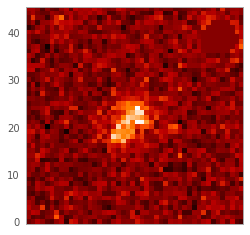

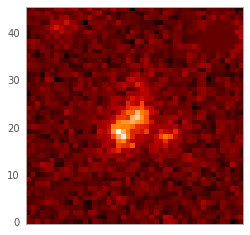

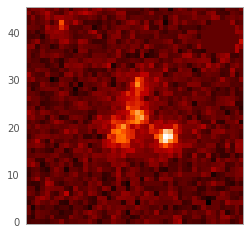

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
Max iteration reached! Stopping.
-2.233132470755835 reduced X^2 of best position
-7060.048306294572 logL
6323.0 effective number of data points
[{'theta_E': 1.726759142470804, 'e1': 0.0831092136844523, 'e2': 0.2643288791081447, 'center_x': 0.32, 'center_y': 0.11}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.8972250672527924, 'n_sersic': 2.2962549312155494, 'e1': -0.22123493301237146, 'e2': 0.09011933229981325, 'center_x': 0.32, 'center_y': 0.11}] lens light result
[{'ra_image': array([-0.73999953,  0.14000087,  2.0199994 ]), 'dec_image': array([-0.60000058,  1.93900749, -0.93000119]), 'point_amp': array([1., 1., 1.])}] point source result
{} special param result
835.1114680767059 time used for  PSO
-1.1616015644174036 reduced X^2 of all evaluated imaging data combin

/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:43: RuntimeWarning: invalid value encountered in log10
  log_model = np.log10(model)
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:136: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,


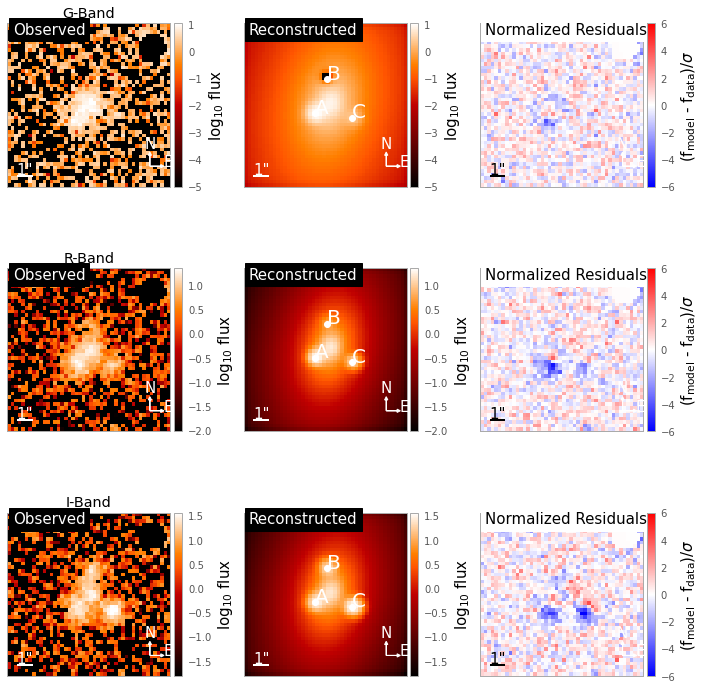

iteration of step 10 gave best reconstruction.
log likelihood before: -1087.5675916893888 and log likelihood after: -1060.3067793013477
iteration of step 18 gave best reconstruction.
log likelihood before: -1215.0712725654457 and log likelihood after: -1123.8068494210333
iteration of step 8 gave best reconstruction.
log likelihood before: -1384.2845012060043 and log likelihood after: -1328.8558112378942


/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/chain_plot.py:159: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(psf_error_map*psf_out**2), origin='lower', **kwargs)


-1.1067956647637918 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.0021803207007067
reduced chi^2 of data  1 =  1.0621992905680844
reduced chi^2 of data  2 =  1.2560073830225842


<Figure size 432x288 with 0 Axes>

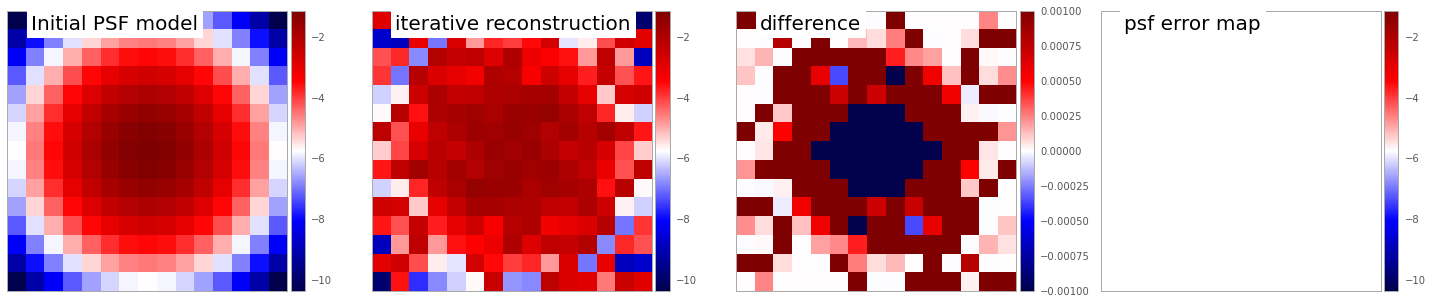

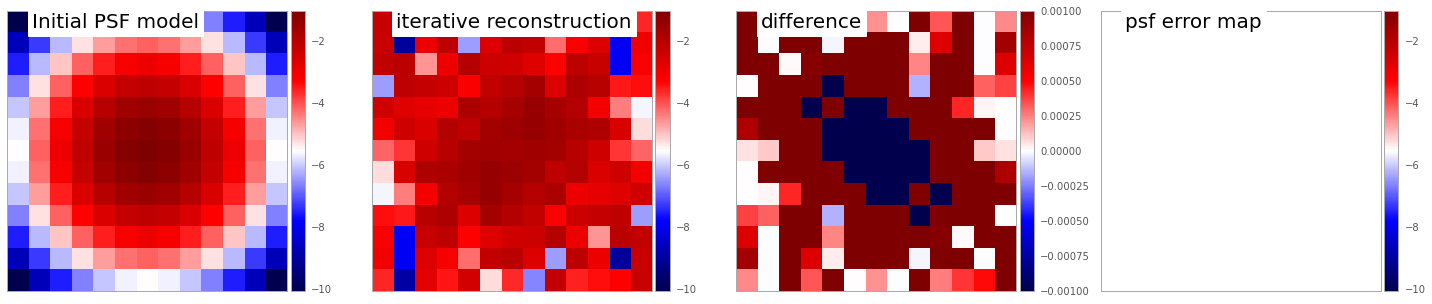

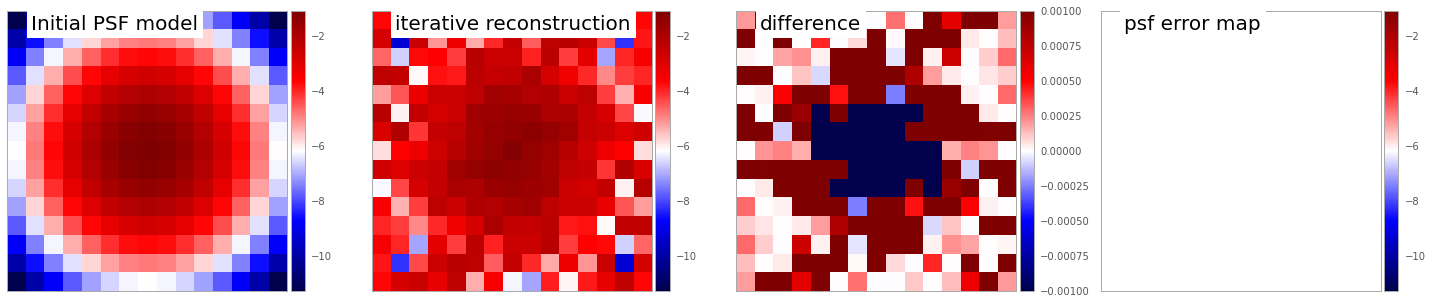

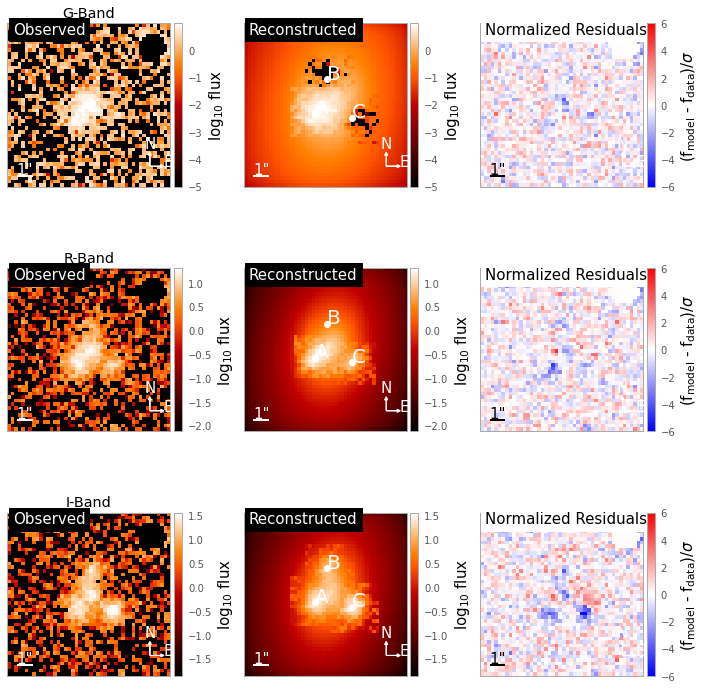

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
Converged after 482 iterations!
Best fit found:  -6884.55951613432 [1.726743025447444, 0.08353264616041597, 0.2644179673085311, 1.8968107171401742, 2.296343497978161, -0.22135333867289, 0.08878007748231087, -0.7399998519582258, 0.14000001779575222, 2.0199996779993383, -0.6000001035033631, 1.9394283119963134, -0.9300000263161416]
-2.1776243922613694 reduced X^2 of best position
-6884.55951613432 logL
6323.0 effective number of data points
[{'theta_E': 1.726743025447444, 'e1': 0.08353264616041597, 'e2': 0.2644179673085311, 'center_x': 0.32, 'center_y': 0.11}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.8968107171401742, 'n_sersic': 2.296343497978161, 'e1': -0.22135333867289, 'e2': 0.08878007748231087, 'center_x': 0.32, 'center_y': 0.11}] lens light result
[{'ra_image': array(

100%|█████████████████████████████████████████| 800/800 [05:58<00:00,  2.23it/s]

Computing the MCMC...
Number of walkers =  130
Burn-in iterations:  200
Sampling iterations (in current run): 800
359.7120587825775 time taken for MCMC sampling


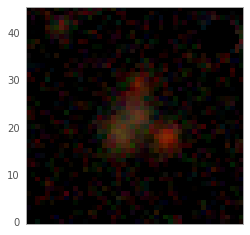

-1.033661935447866 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9939435530827374
reduced chi^2 of data  1 =  1.016070571075961
reduced chi^2 of data  2 =  1.0909716821848996


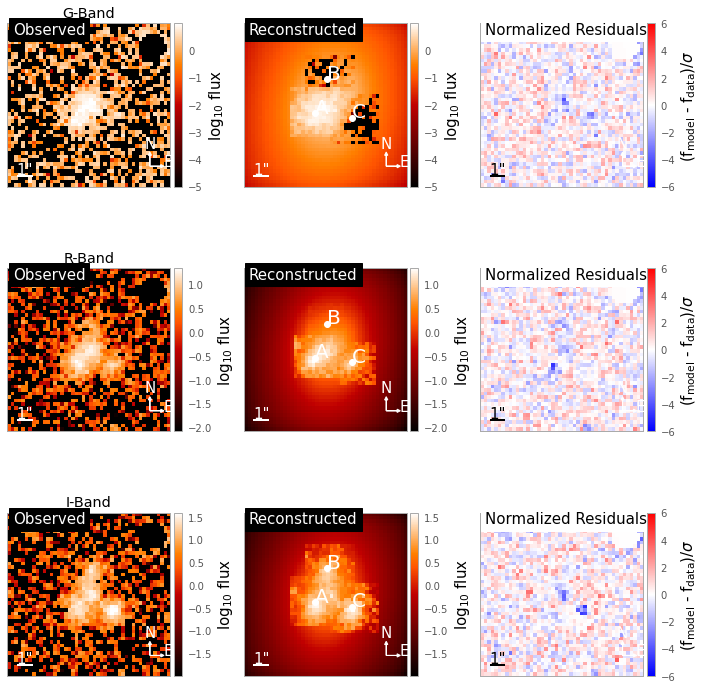

number of non-linear parameters in the MCMC process: 13
parameters in order: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image']
number of evaluations in the MCMC process: 78000
number of samples: 78000


Total Memory Usage: 467.20703125


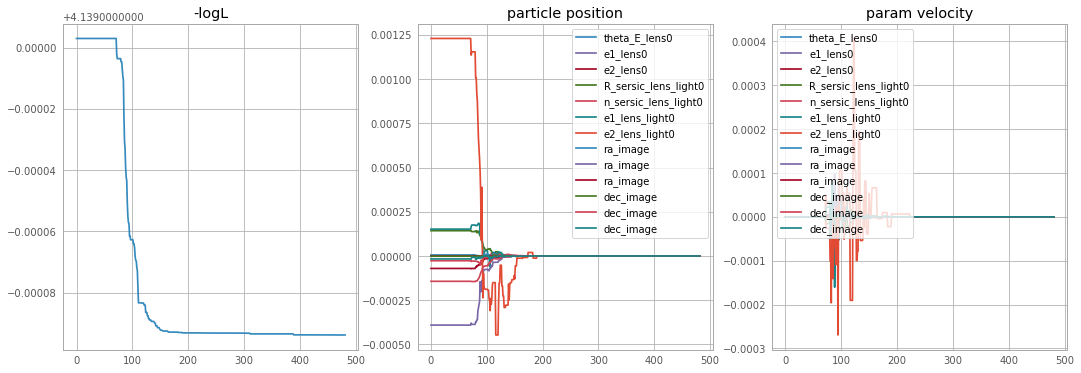

<Figure size 432x288 with 0 Axes>

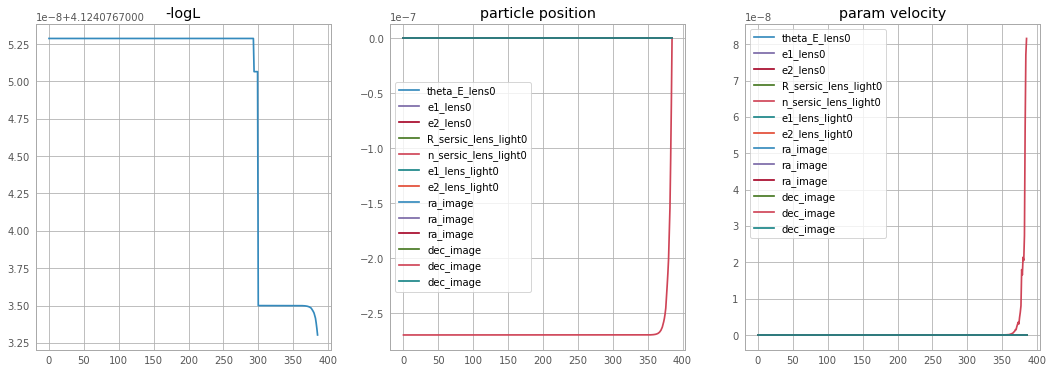

<Figure size 432x288 with 0 Axes>

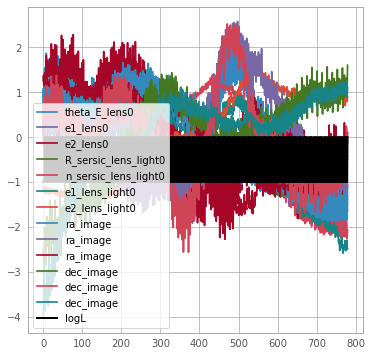

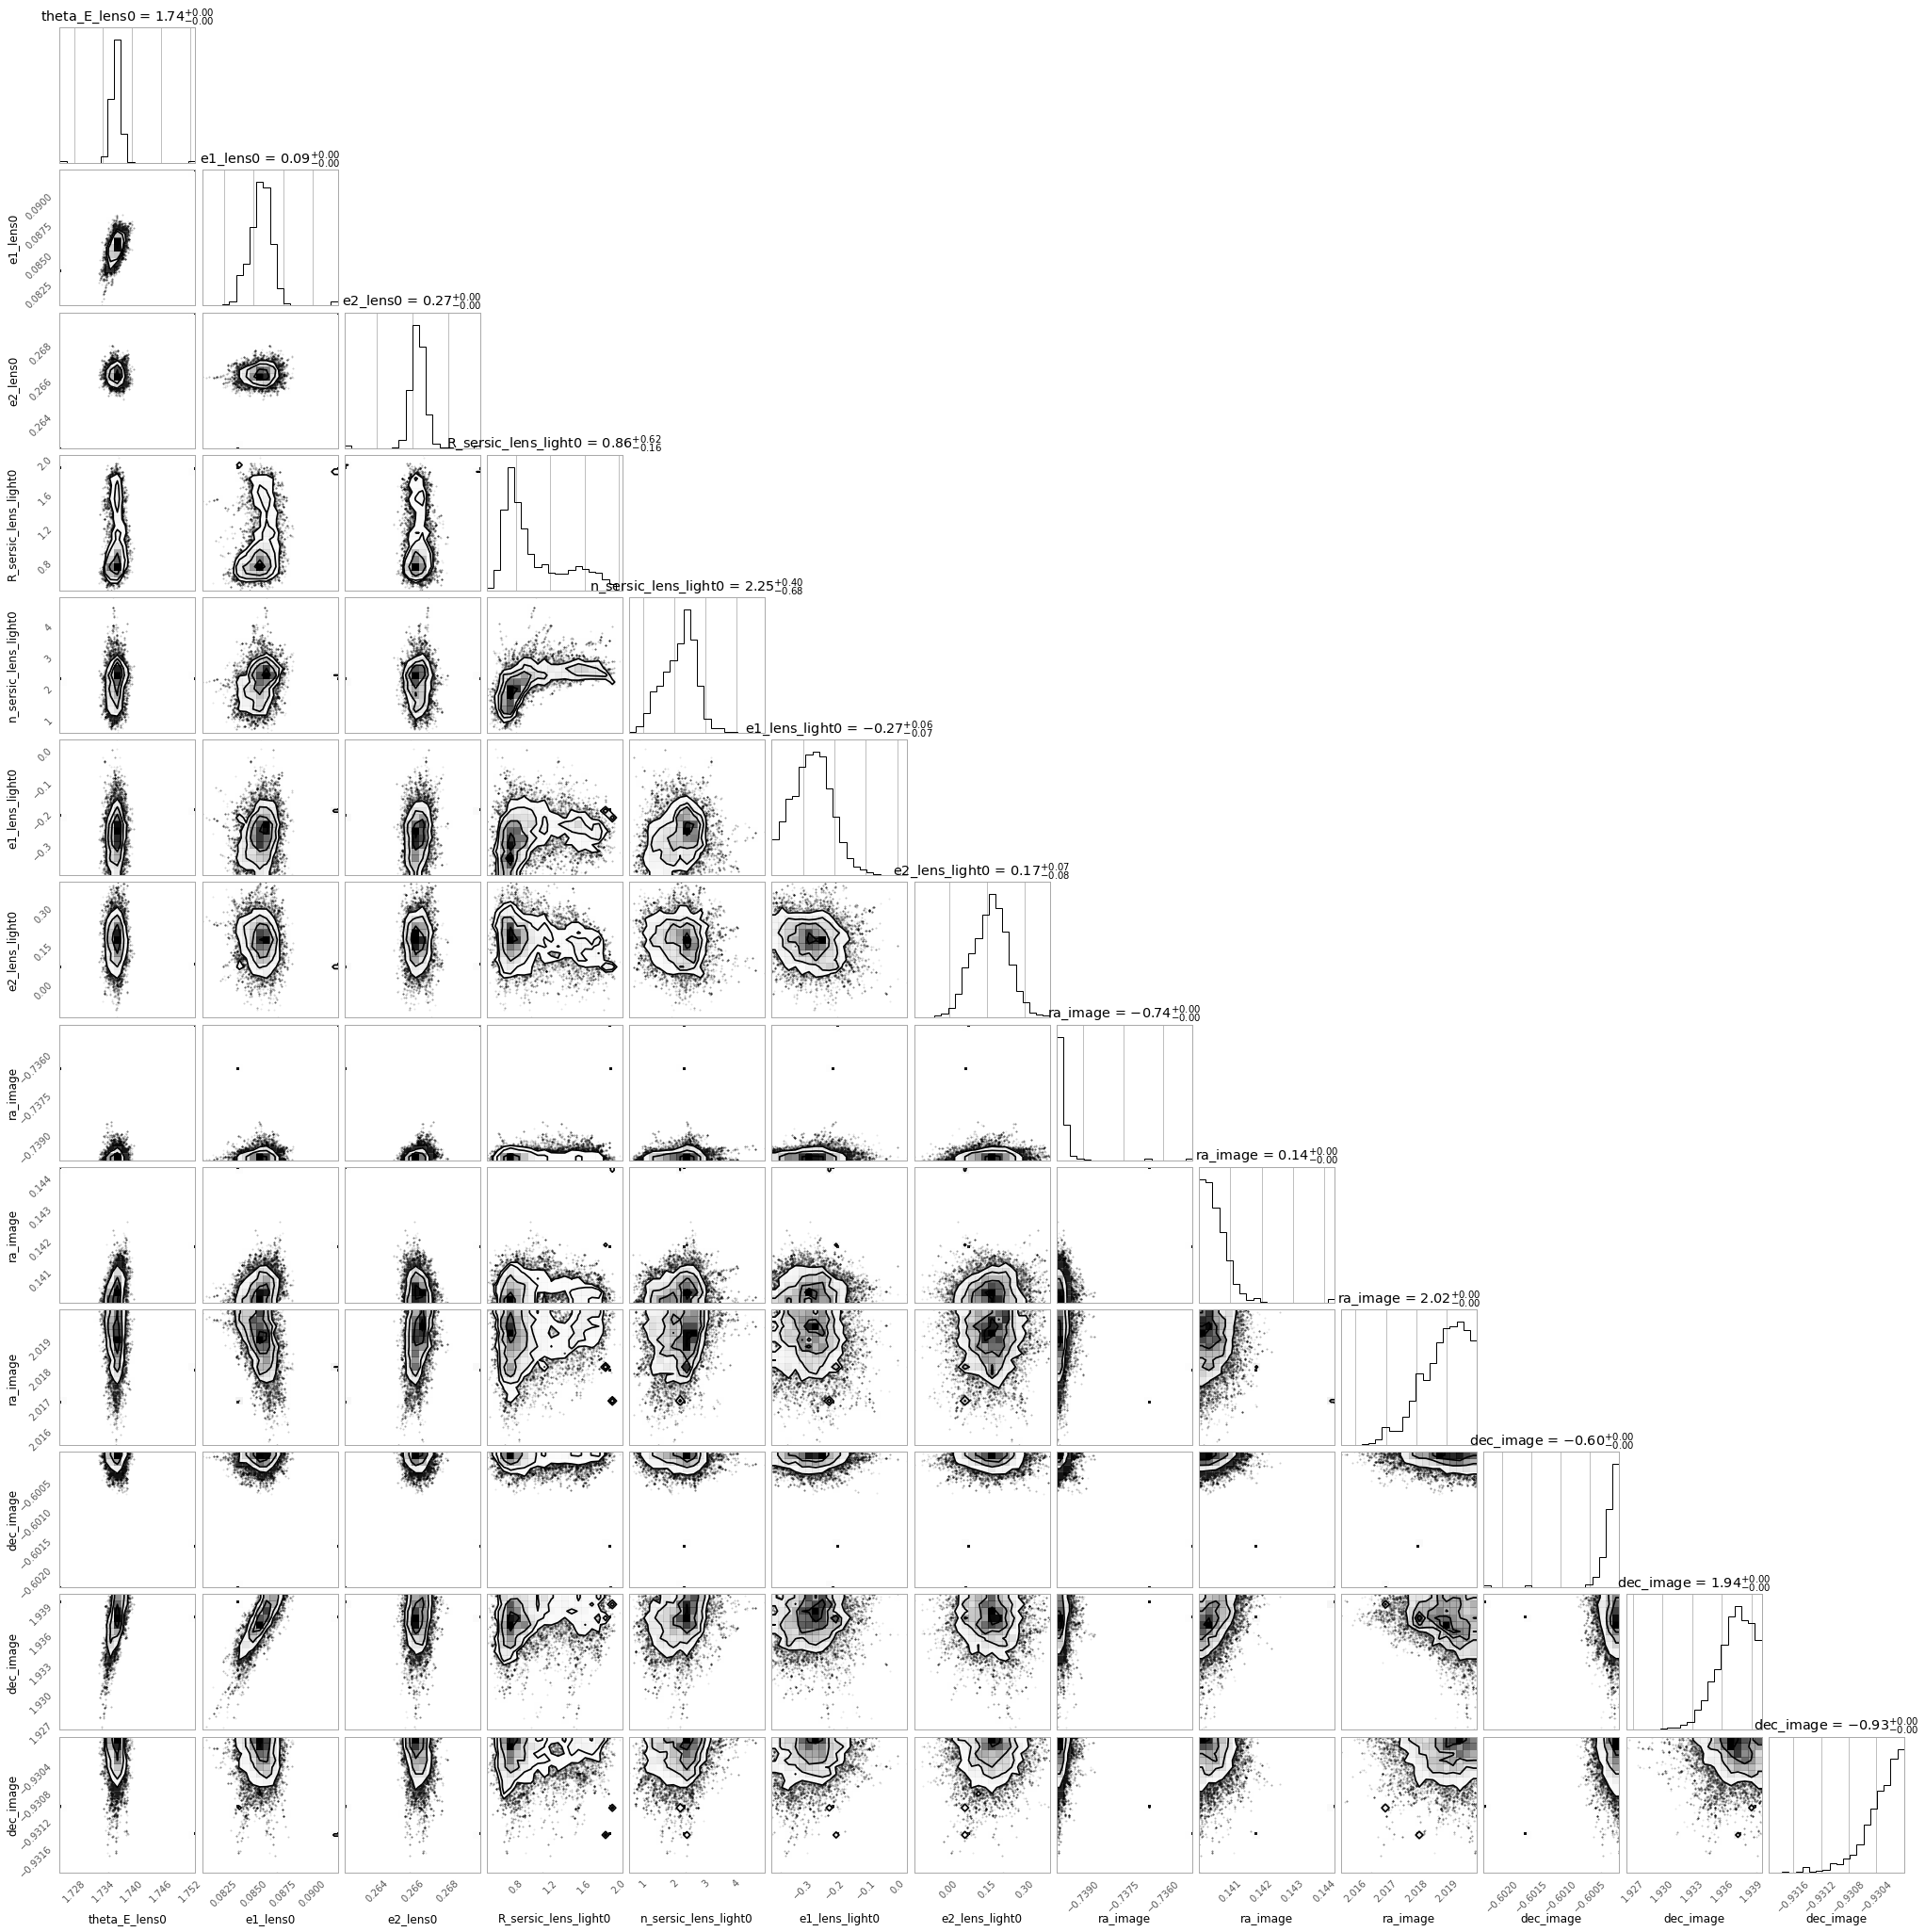

In [20]:
# DES_2915, coadd_id = 1400263522

# background_rms
crop = [[85, 114], [85, 114]]
rms_list = get_rms_fast(rms_filename, 1400263522, crop)

# image positions
x_images = [-0.54, 0.34, 1.82]
y_images = [-0.8, 1.74, -1.13]

# lens position
center_x = 0.32
center_y = 0.11

# initial guesses for params
theta_E = approx_theta_E(center_x, center_y, x_images, y_images)

kwargs_lens_initial = {'theta_E': theta_E, 'e1': 0.15, 'e2': 0.1,
                       'center_x': center_x, 'center_y': center_y}

kwargs_lens_light_initial = {'R_sersic': 1, 'n_sersic': 2,
                             'e1': -0.15, 'e2': 0.0,
                             'center_x': center_x, 'center_y': center_y}

mem_usage = memory_usage((model,
                          (1400263522, kwargs_lens_initial,
                           kwargs_lens_light_initial,
                           x_images, y_images,
                           [{'mask_x': 4.7, 'mask_y': 4.3, 'mask_r': 1}],
                           'GAUSSIAN', rms_list), ))

print(f"Total Memory Usage: {mem_usage[-1]}")

### Summary:
* No source light, lens position fixed
* number of free params: 13
* PSO:
    * Particles=500, iterations=500
    * Convereged on second PSO after 482 iterations
    * Converged on third PSO after 386 iterations
    * Times: 14, 20, 16.4 min
* MCMC
    * burn=200, run=600, walkerRatio=10
    * time: 6 min
* Last psf reconstruction found on steps: 7, 9, 17
* Memory usage: 467
* Total time: 56.5 min

'Estimated theta_E': 2.02
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
Max iteration reached! Stopping.
-21.52221789642496 reduced X^2 of best position
-68042.49187954751 logL
6323.0 effective number of data points
[{'theta_E': 2.0062726512959506, 'e1': -0.11202602970947012, 'e2': 0.11561337431589874, 'center_x': 1.4, 'center_y': -1.6}] lens result
[] source result
[{'amp': 1, 'R_sersic': 2.7500578907596354, 'n_sersic': 4.99999108936187, 'e1': 0.021389735690728346, 'e2': -0.06028578013767954, 'center_x': 1.4, 'center_y': -1.6}] lens light result
[{'ra_image': array([0.10999951, 0.20999957, 3.60999908]), 'dec_image': array([-0.09999823, -2.8899999 , -2.05999981]), 'point_amp': array([1., 1., 1.])}] point source result
{} special param result
908.1003682613373 time used for  PSO
-18.261185135789187 reduced X^2 of all evalu

/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


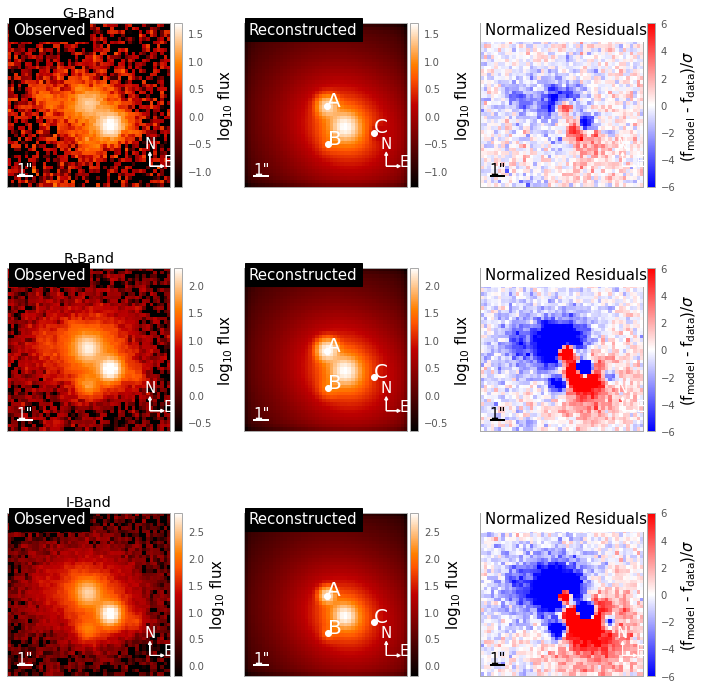

iteration of step 2 gave best reconstruction.
log likelihood before: -2264.022565440701 and log likelihood after: -2196.9990587934376
iteration of step 1 gave best reconstruction.
log likelihood before: -15454.227374904342 and log likelihood after: -15242.79961776048
iteration of step 1 gave best reconstruction.
log likelihood before: -40242.75168064984 and log likelihood after: -40150.11386439955


/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/chain_plot.py:159: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(psf_error_map*psf_out**2), origin='lower', **kwargs)


-18.14426986167406 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  2.0765586567045724
reduced chi^2 of data  1 =  14.40718300355433
reduced chi^2 of data  2 =  37.949067924763284


<Figure size 432x288 with 0 Axes>

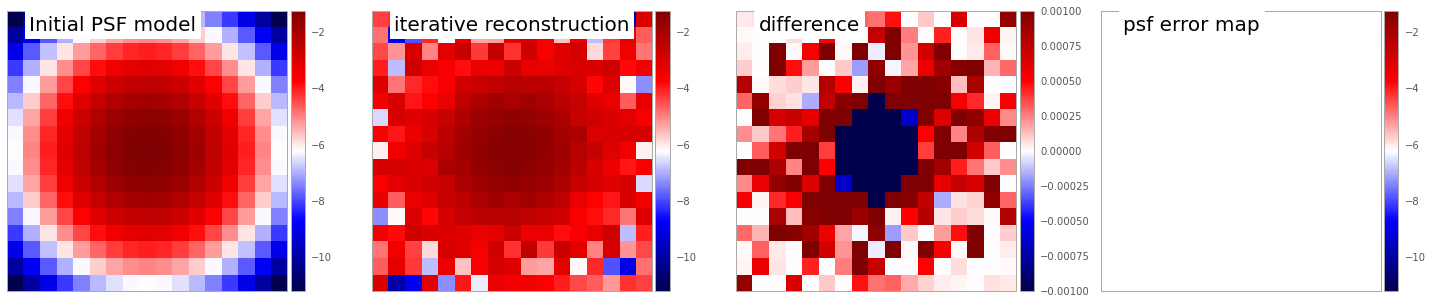

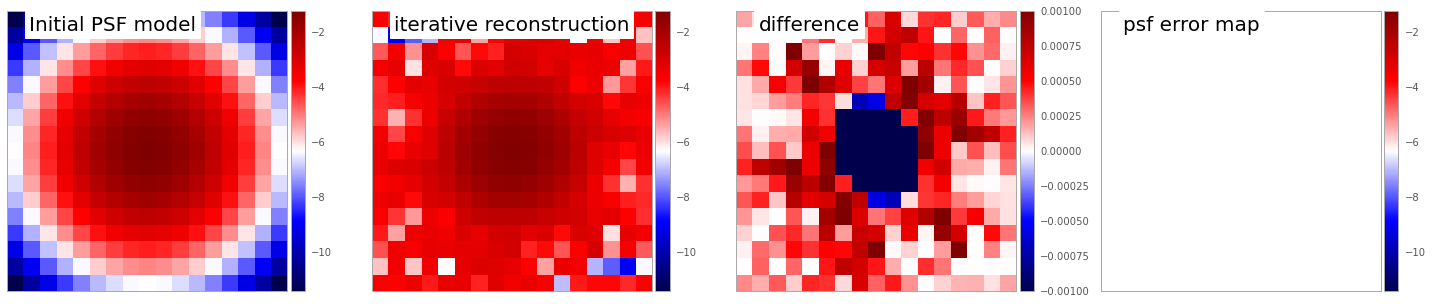

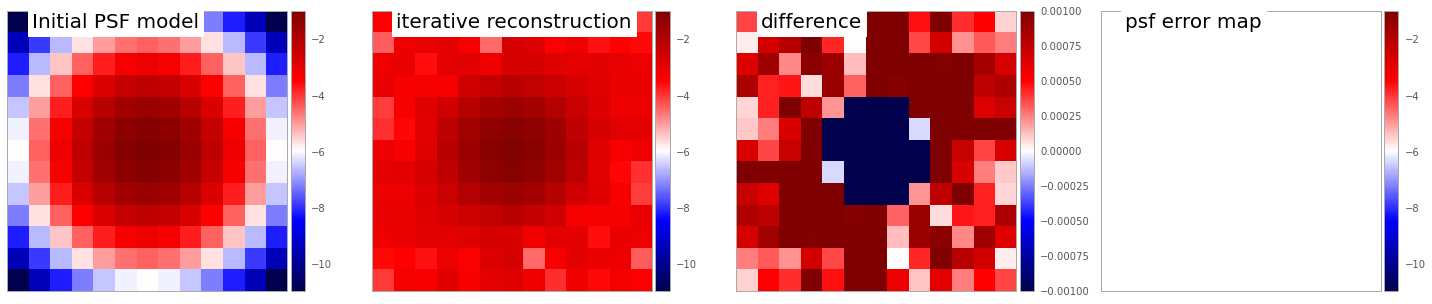

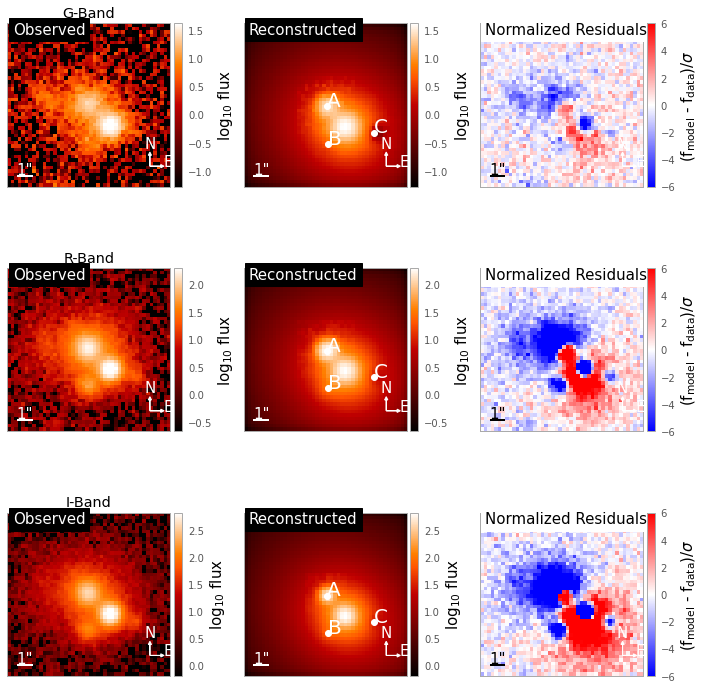

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
Max iteration reached! Stopping.
-21.129762307852793 reduced X^2 of best position
-66801.74353627661 logL
6323.0 effective number of data points
[{'theta_E': 2.006497355149536, 'e1': -0.11205669973709012, 'e2': 0.11566204846170526, 'center_x': 1.4, 'center_y': -1.6}] lens result
[] source result
[{'amp': 1, 'R_sersic': 1.8106262607098091, 'n_sersic': 4.999995652055012, 'e1': 0.018638187640172728, 'e2': -0.041810195306650616, 'center_x': 1.4, 'center_y': -1.6}] lens light result
[{'ra_image': array([0.10999926, 0.2099993 , 3.60999951]), 'dec_image': array([-0.09999828, -2.88999982, -2.05999918]), 'point_amp': array([1., 1., 1.])}] point source result
{} special param result
1206.9396760463715 time used for  PSO
iteration of step 2 gave best reconstruction.
log likelihood before

100%|█████████████████████████████████████████| 800/800 [06:41<00:00,  1.99it/s]

Computing the MCMC...
Number of walkers =  130
Burn-in iterations:  200
Sampling iterations (in current run): 800
402.6230342388153 time taken for MCMC sampling


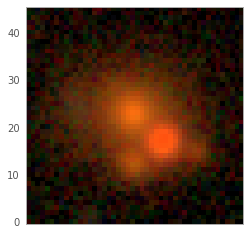

-15.755690530639468 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  2.00745333770476
reduced chi^2 of data  1 =  11.993641154666868
reduced chi^2 of data  2 =  33.265977099546774


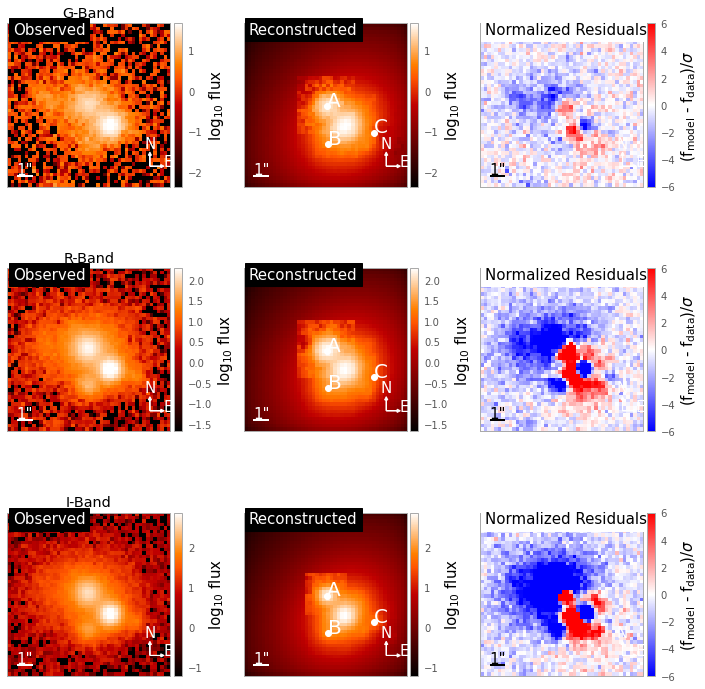

number of non-linear parameters in the MCMC process: 13
parameters in order: ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image']
number of evaluations in the MCMC process: 78000
number of samples: 78000
Total Memory Usage: 493.1875


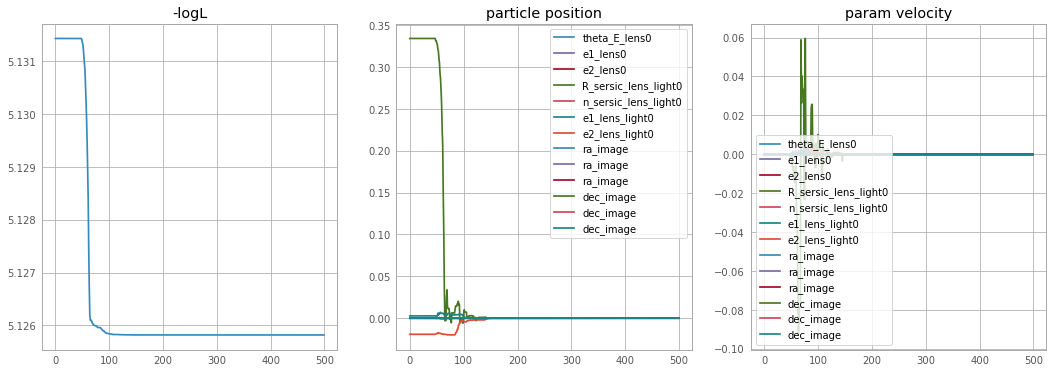

<Figure size 432x288 with 0 Axes>

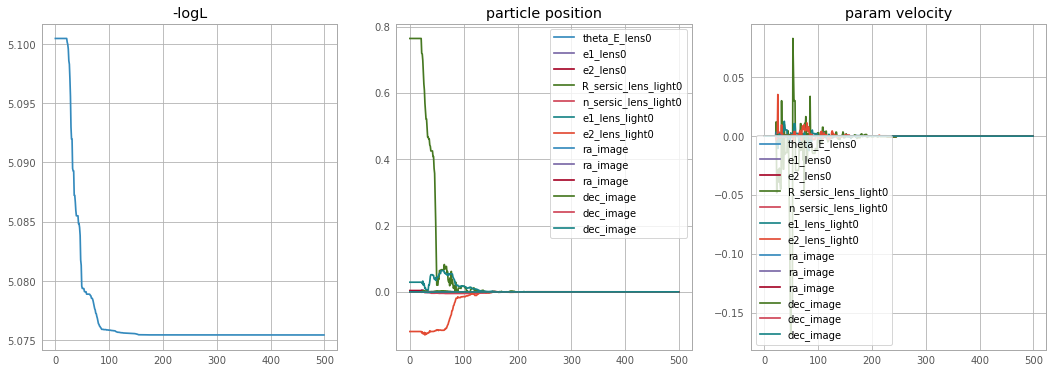

<Figure size 432x288 with 0 Axes>

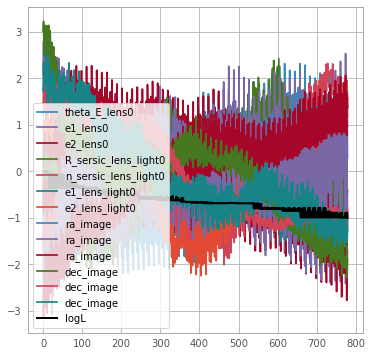

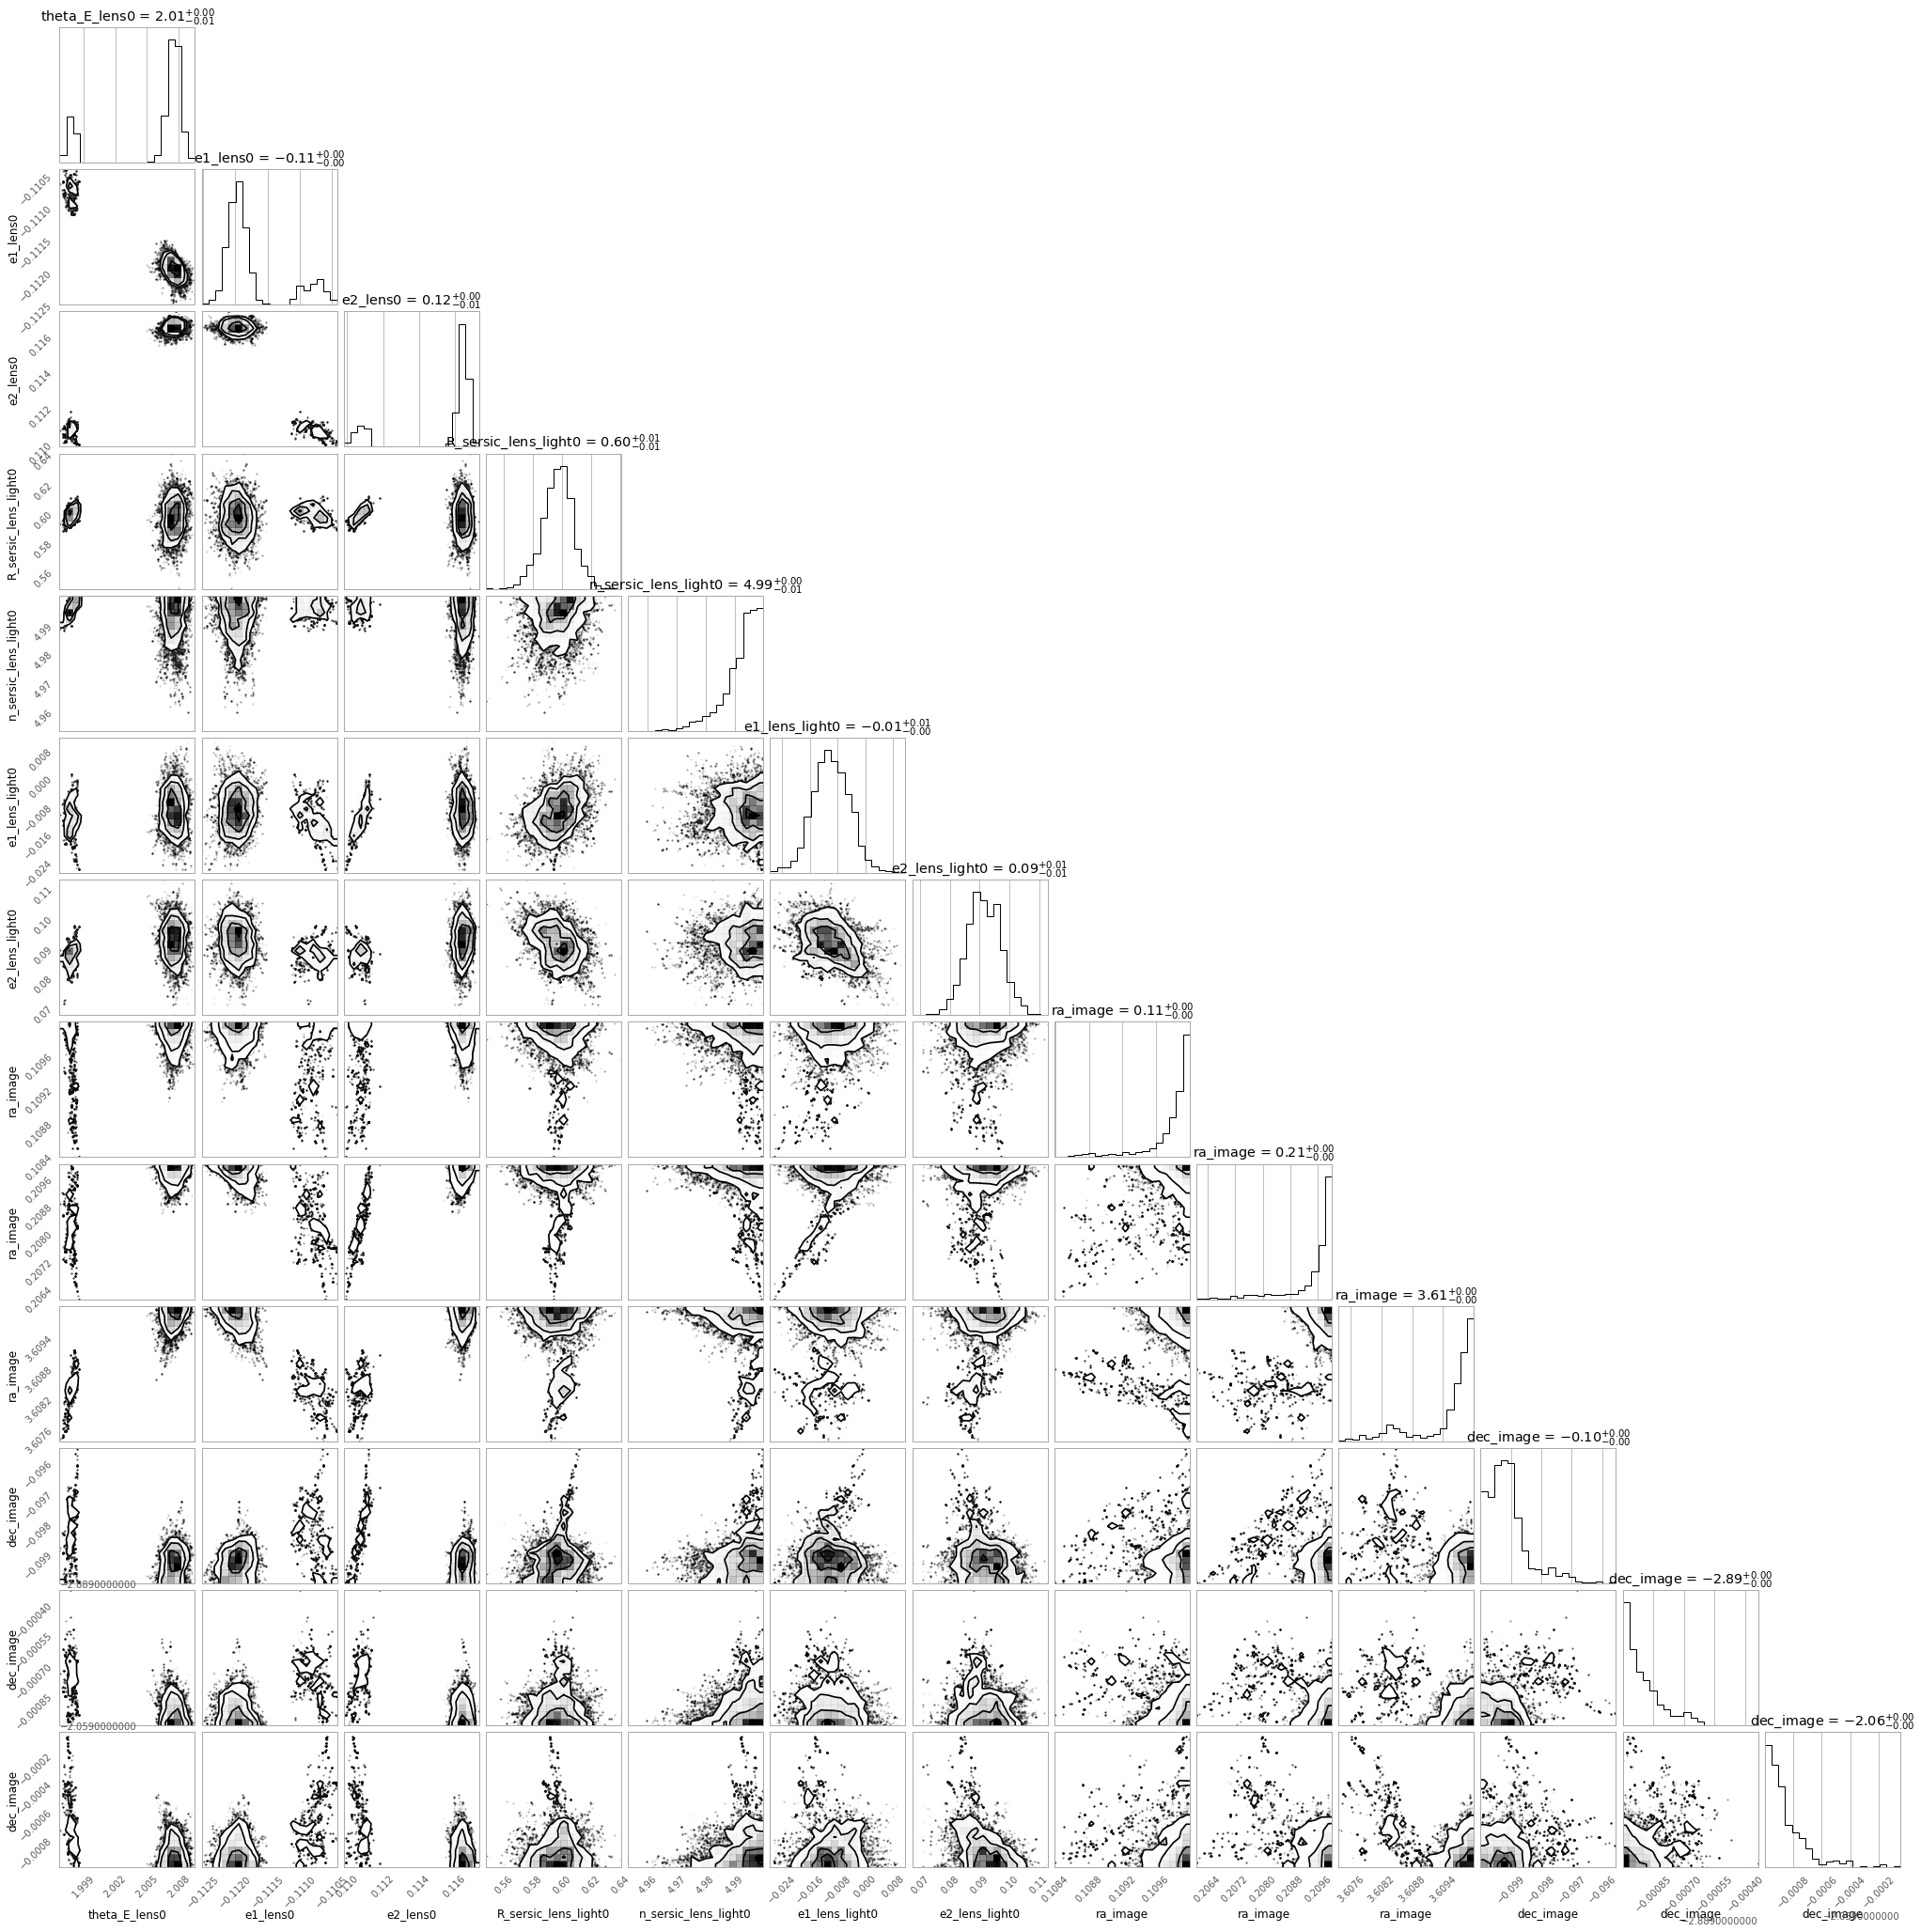

In [21]:
# DES_4414, coadd_id = 1087262176

# background_rms
crop = [[0, 35], [0, 35]]
rms_list = get_rms_fast(rms_filename, 1087262176, crop)

# lens position:
center_x = 1.4
center_y = -1.6

# image positions:
x_images = [-0.09, 0.01, 3.41]
y_images = [0.10, -2.69, -1.86]

# initial guesses for params
theta_E = approx_theta_E(center_x, center_y, x_images, y_images)

kwargs_lens_initial = {'theta_E': theta_E, 'e1': -0.3, 'e2': 0,
                       'center_x': center_x, 'center_y': center_y}

kwargs_lens_light_initial = {'R_sersic': 1, 'n_sersic': 2,
                             'e1': 0, 'e2': 0,
                             'center_x': center_x, 'center_y': center_y}

mem_usage = memory_usage((model, (1087262176, kwargs_lens_initial,
                                  kwargs_lens_light_initial,
                                  x_images, y_images,
                                  None, 'GAUSSIAN', rms_list), ))

print(f"Total Memory Usage: {mem_usage[-1]}")
print("================================================================")


### Summary:
* No source light, lens position fixed
* number of free params: 13
* PSO:
    * Particles=500, iterations=500
    * None of the PSOs converged
    * Times: 15, 20, 19.5
* MCMC
    * burn=200, run=600, walkerRatio=10
    * time: 7 min
* Last psf reconstruction found on steps: 2, 3, 2
* Memory usage: 500
* Total time: 61.5 min